In [1]:
import torch 
from torch import Tensor 
import numpy as np
import math
import matplotlib.pyplot as plt

## Data Generation

In [118]:
data = torch.FloatTensor(1000,2).uniform_(0,1)
distance = torch.sqrt(torch.pow(data[:, 0], 2) + torch.pow(data[:,1],2)).view(-1,1)
radius = 1 / math.sqrt(2 * math.pi)
inside = distance.clone().apply_(lambda x : 1 if x < radius else  0)
outside = distance.clone().apply_(lambda x : 1 if x > radius else  0)

target = torch.cat((inside, outside),1)

In [123]:
data


 0.4481  0.7923
 0.1819  0.0629
 0.0058  0.4816
       ⋮        
 0.5267  0.4002
 0.4355  0.8443
 0.5613  0.8281
[torch.FloatTensor of size 1000x2]

In [124]:
distance



 0.9102
 0.1925
 0.4817
   ⋮    
 0.6615
 0.9500
 1.0004
[torch.FloatTensor of size 1000x1]

In [125]:
radius

0.3989422804014327

In [126]:
target



    0     1
    1     0
    0     1
     ⋮      
    0     1
    0     1
    0     1
[torch.FloatTensor of size 1000x2]

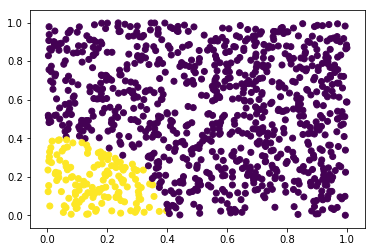

In [127]:
plt.scatter(data[:,0], data[:,1], c=inside)
plt.show()

## ReLu

In [28]:
class Relu:
    
    def forward(self, X):   
        return X.clamp(min=0)
    
    def backward(self, dz):
        output = dz.clone()
        output[output > 0] = 1
        output[output <= 0] = 0
        return output
    

## Tanh Module


In [29]:
class Tanh:
    
    def forward(self, X):
        self.output = Tensor.tanh(X)
        return self.output;

    def backward(self, dz):
        return (1.0 - Tensor.pow(self.output,2)) * dz
        

## LossMSE Module

In [30]:
class LossMSE: 
        
    def forward(self, t, x):
        loss = (t - x).pow(2).sum()
        return loss
    
    def backward(self, t, x):
        return - 2 * (t - x)

## Linear Module

In [70]:
class Linear:
    
    def __init__(self, input_size ,hidden_nodes):    
        
        # Initialize weight, bias xavie initializer
        self.w = Tensor(hidden_nodes, input_size).normal_(0,1e-1) / math.sqrt(input_size)
        self.b = Tensor(hidden_nodes).normal_(0,1e-1) / math.sqrt(input_size)
        
    def forward(self, x):
        self.x = x
        s = x.mm(self.w.t()) + self.b
        return s
        
    def backward(self, dz, lambda_):
        
        dx = dz.mm(self.w)
        dw = self.x.t().mm(dz)
        db = dz.t().sum(1).squeeze_()
        
        # update weight and bias
        self.w = self.w - lambda_ * dw
        self.b = self.b - lambda_ * db
                
        return dx
        
    def params(self):
        return (self.w, self.b)
    
    
    

## Sequential Module

In [71]:
class Sequential:
    
    def __init__(self, layer_modules, epsilon, activation_func, output_func):
        
        self.layer_modules = layer_modules
        self.activation_func = activation_func
        self.output_func = output_func

    def forward(self, x_input):
        
        result = x_input
        
        # hidden layer
        for i in range(len(self.layer_modules) - 1): 
            result = self.layer_modules[i].forward(result)
            result = self.activation_func.forward(result)
      

        # output layer
        result = self.layer_modules[-1].forward(result)
        result = self.output_func.forward(result)
        return result
    
    def backward(self, dz, lambda_):
        dz = self.output_func.backward(dz)
        
        for i in range(len(self.layer_modules) - 1, 0, -1):
            dz = self.layer_modules[i].backward(dz,lambda_)
            dz = self.activation_func.backward(dz)
        
        dz = self.layer_modules[0].backward(dz, lambda_)



    
        return dz
    def get_params(self):
        for m in self.layer_modules:
            print('{},{}'.format(m.params()[0], m.params()[1]))


In [129]:
lambda_ = 0.001
train_data, train_target, test_data, test_target = data[0:800,], target[0:800,], data[800:,], target[800:,]
no_iter = 5



modules = list([Linear(2, 25), Linear(25, 25), Linear(25, 25), Linear(25, 2)])


seq = Sequential(modules, 0.01, Relu(), Tanh())

# Initialize loss function
loss_mse = LossMSE()
    

## SGD 
for n in range(no_iter): 
   
    
    # Random sampling
    randomInt  = np.random.randint(800, size=(1))[0]
    sample_data = train_data[randomInt, :].view(-1,2)
    sample_target = train_target[randomInt, :].view(-1,2)
    

    # Forward path
    nn_output = seq.forward(sample_data)
  
    loss_mse.forward(sample_target,nn_output)
    # Backward path (update weight and bias)
    dz = loss_mse.backward(sample_target, nn_output)
    seq.backward(dz, lambda_)
    
    # Compute Loss
    train_loss = loss_mse.forward(train_target,seq.forward(train_data))
    
    

    # compute train accuracy 
    train_errors = 0
    for i in range(train_data.shape[0]):
        pred = seq.forward(train_data[i,:].view(-1,2)).max(1)[1][0]
        if train_target[i, pred] == 0:
             train_errors += 1
    
    
    # comput test accuracy
    test_errors = 0
    for i in range(test_data.shape[0]):
        
        pred = seq.forward(test_data[i,:].view(-1,2)).max(1)[1][0]
        if test_target[i, pred] == 0: 
             test_errors += 1
   

    # 
    print('{:d} train_loss {:.02f} train_error {:.02f}% test_error {:.02f}%'
          .format(n,
                  train_loss,
                  (100 * train_errors) / train_data.size(0),
                  (100 * test_errors) / test_data.size(0)))



/usr/local/lib/python3.6/site-packages/torch/tensor.py:312: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.sub(other)



 0.2668  0.1480
[torch.FloatTensor of size 1x2]


 0.9102
[torch.FloatTensor of size 1]


 1  0
[torch.FloatTensor of size 1x2]


1.00000e-02 *
 -1.7599  1.7432
[torch.FloatTensor of size 1x2]


 0.6087  0.0334
[torch.FloatTensor of size 1x2]


 0.1925
[torch.FloatTensor of size 1]


 0  1
[torch.FloatTensor of size 1x2]


1.00000e-02 *
 -1.8437  1.5552
[torch.FloatTensor of size 1x2]


 0.1618  0.8998
[torch.FloatTensor of size 1x2]


 0.4817
[torch.FloatTensor of size 1]


 0  1
[torch.FloatTensor of size 1x2]


1.00000e-02 *
 -1.5398  1.5987
[torch.FloatTensor of size 1x2]


 0.6584  0.5931
[torch.FloatTensor of size 1x2]


 1.0760
[torch.FloatTensor of size 1]


 0  1
[torch.FloatTensor of size 1x2]


1.00000e-02 *
 -1.9184  1.5331
[torch.FloatTensor of size 1x2]


 0.6179  0.1987
[torch.FloatTensor of size 1x2]


 0.9424
[torch.FloatTensor of size 1]


 0  1
[torch.FloatTensor of size 1x2]


1.00000e-02 *
 -1.9387  1.5885
[torch.FloatTensor of size 1x2]


 0.9101  0.3455
[torch.F


 0.8883
[torch.FloatTensor of size 1]


 1  0
[torch.FloatTensor of size 1x2]


1.00000e-02 *
 -1.6079  1.8230
[torch.FloatTensor of size 1x2]


 0.0299  0.5208
[torch.FloatTensor of size 1x2]


 0.7266
[torch.FloatTensor of size 1]


 0  1
[torch.FloatTensor of size 1x2]


1.00000e-02 *
 -1.6348  1.8590
[torch.FloatTensor of size 1x2]


 0.7942  0.4956
[torch.FloatTensor of size 1x2]


 0.2176
[torch.FloatTensor of size 1]


 0  1
[torch.FloatTensor of size 1x2]


1.00000e-02 *
 -1.9752  1.4746
[torch.FloatTensor of size 1x2]


 0.6982  0.5263
[torch.FloatTensor of size 1x2]


 0.5701
[torch.FloatTensor of size 1]


 0  1
[torch.FloatTensor of size 1x2]


1.00000e-02 *
 -1.9424  1.5168
[torch.FloatTensor of size 1x2]


 0.1787  0.8992
[torch.FloatTensor of size 1x2]


 0.7532
[torch.FloatTensor of size 1]


 0  1
[torch.FloatTensor of size 1x2]


1.00000e-02 *
 -1.5486  1.5939
[torch.FloatTensor of size 1x2]


 0.1534  0.8710
[torch.FloatTensor of size 1x2]


 1.1758
[torch.FloatTens



 0.2463  0.7285
[torch.FloatTensor of size 1x2]


 0.1214
[torch.FloatTensor of size 1]


 0  1
[torch.FloatTensor of size 1x2]


1.00000e-02 *
 -1.6638  1.9001
[torch.FloatTensor of size 1x2]


 0.5536  0.6547
[torch.FloatTensor of size 1x2]


 0.9407
[torch.FloatTensor of size 1]


 0  1
[torch.FloatTensor of size 1x2]


1.00000e-02 *
 -1.8615  1.7973
[torch.FloatTensor of size 1x2]


 0.4890  0.7512
[torch.FloatTensor of size 1x2]


 0.9483
[torch.FloatTensor of size 1]


 0  1
[torch.FloatTensor of size 1x2]


1.00000e-02 *
 -1.7910  1.7953
[torch.FloatTensor of size 1x2]


 0.8445  0.4764
[torch.FloatTensor of size 1x2]


 0.8548
[torch.FloatTensor of size 1]


 0  1
[torch.FloatTensor of size 1x2]


1.00000e-02 *
 -1.9792  1.6749
[torch.FloatTensor of size 1x2]


 0.7602  0.9533
[torch.FloatTensor of size 1x2]


 1.3246
[torch.FloatTensor of size 1]


 0  1
[torch.FloatTensor of size 1x2]


1.00000e-02 *
 -1.7786  1.6443
[torch.FloatTensor of size 1x2]


 0.0645  0.3921
[torch.


 0.3709  0.4182
[torch.FloatTensor of size 1x2]


 0.7146
[torch.FloatTensor of size 1]


 0  1
[torch.FloatTensor of size 1x2]


1.00000e-02 *
 -1.8425  2.1381
[torch.FloatTensor of size 1x2]


 0.1315  0.4655
[torch.FloatTensor of size 1x2]


 1.0740
[torch.FloatTensor of size 1]


 0  1
[torch.FloatTensor of size 1x2]


1.00000e-02 *
 -1.7016  2.2496
[torch.FloatTensor of size 1x2]


 0.8027  0.9514
[torch.FloatTensor of size 1x2]


 0.9852
[torch.FloatTensor of size 1]


 0  1
[torch.FloatTensor of size 1x2]


1.00000e-02 *
 -1.7875  1.8482
[torch.FloatTensor of size 1x2]


 0.5462  0.9045
[torch.FloatTensor of size 1x2]


 0.6904
[torch.FloatTensor of size 1]


 0  1
[torch.FloatTensor of size 1x2]


1.00000e-02 *
 -1.7332  1.9492
[torch.FloatTensor of size 1x2]


 0.2920  0.7883
[torch.FloatTensor of size 1x2]


 0.8920
[torch.FloatTensor of size 1]


 0  1
[torch.FloatTensor of size 1x2]


1.00000e-02 *
 -1.6493  2.0517
[torch.FloatTensor of size 1x2]


1.00000e-02 *
  6.2610  



 0  1
[torch.FloatTensor of size 1x2]


1.00000e-02 *
 -1.9408  2.1763
[torch.FloatTensor of size 1x2]


 0.0384  0.1970
[torch.FloatTensor of size 1x2]


 0.8674
[torch.FloatTensor of size 1]


 1  0
[torch.FloatTensor of size 1x2]


1.00000e-02 *
 -1.6497  2.5205
[torch.FloatTensor of size 1x2]


 0.5403  0.2172
[torch.FloatTensor of size 1x2]


 0.4705
[torch.FloatTensor of size 1]


 0  1
[torch.FloatTensor of size 1x2]


1.00000e-02 *
 -1.9252  2.2923
[torch.FloatTensor of size 1x2]


 0.1356  0.1180
[torch.FloatTensor of size 1x2]


 0.3280
[torch.FloatTensor of size 1]


 1  0
[torch.FloatTensor of size 1x2]


1.00000e-02 *
 -1.6862  2.4617
[torch.FloatTensor of size 1x2]


 0.2607  0.6974
[torch.FloatTensor of size 1x2]


 0.1429
[torch.FloatTensor of size 1]


 0  1
[torch.FloatTensor of size 1x2]


1.00000e-02 *
 -1.6822  2.3429
[torch.FloatTensor of size 1x2]


 0.3670  0.4802
[torch.FloatTensor of size 1x2]


 1.2529
[torch.FloatTensor of size 1]


 0  1
[torch.FloatTenso


 0  1
[torch.FloatTensor of size 1x2]


1.00000e-02 *
 -1.6030  2.4446
[torch.FloatTensor of size 1x2]


 0.1220  0.1584
[torch.FloatTensor of size 1x2]


 1.1197
[torch.FloatTensor of size 1]


 1  0
[torch.FloatTensor of size 1x2]


1.00000e-02 *
 -1.6902  2.6948
[torch.FloatTensor of size 1x2]


 0.4072  0.0098
[torch.FloatTensor of size 1x2]


 0.9542
[torch.FloatTensor of size 1]


 0  1
[torch.FloatTensor of size 1x2]


1.00000e-02 *
 -1.7570  2.5279
[torch.FloatTensor of size 1x2]


 0.2795  0.4971
[torch.FloatTensor of size 1x2]


 0.7471
[torch.FloatTensor of size 1]


 0  1
[torch.FloatTensor of size 1x2]


1.00000e-02 *
 -1.7664  2.6026
[torch.FloatTensor of size 1x2]


 0.0071  0.3038
[torch.FloatTensor of size 1x2]


 0.9520
[torch.FloatTensor of size 1]


 1  0
[torch.FloatTensor of size 1x2]


1.00000e-02 *
 -1.6682  2.7731
[torch.FloatTensor of size 1x2]


 0.8777  0.4561
[torch.FloatTensor of size 1x2]


 0.9008
[torch.FloatTensor of size 1]


 0  1
[torch.FloatTensor

In [82]:
 seq.forward(test_data[1,:].view(-1,2))


 0.1203  0.7879
[torch.FloatTensor of size 1x2]